# <b> <font color='#A20025'> 📚 Chapter 3: Ligand-based Screening: Machine Learning

*This notebook contains the code examples in chapter 3. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH03_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- The end-to-end process of a machine learning project in the context of cardiotoxicity prediction
- How to acquire, curate, and standardize molecule datasets
- Training and evaluating a linear model, which we can save for later use
- How to improve our model with regularization and non-linear transformations
- Hyperparameter tuning with grid search and randomized search

## <b> <font color='#A20025'> ⚙️ Environment Setup

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch03"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch03/hERG_blockers.xlsx" -O "data/ch03/hERG_blockers.xlsx"
!wget "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" -O "env.yml"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [96]:
# Standard libraries
import numpy as np
import pandas as pd
from pathlib import Path
import urllib.request
import joblib

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, 
    matthews_corrcoef, precision_score, recall_score
)
from scipy.stats import uniform as sp_rand

# RDKit libraries for cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize.rdMolStandardize import (
    Cleanup, LargestFragmentChooser, TautomerEnumerator, Uncharger
)
from rdkit.Chem.rdFingerprintGenerator import AdditionalOutput, GetMorganGenerator

# Utility functions
from utils import (
    save_molecular_dataframe,
    load_molecular_dataframe,
    list_saved_dataframes,
)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [60]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    colors = ["#A20025", "#6C8EBF"]  # Define a color palette
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['legend.fontsize'] = 16   
    plt.rcParams['xtick.labelsize'] = 16   
    plt.rcParams['ytick.labelsize'] = 16    

setup_visualization_style()
%matplotlib inline

In [3]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

## <b> <font color='#A20025'> 1️⃣ Problem Understanding

*Companion code does not accompany this section of the book.*

## <b> <font color='#A20025'> 2️⃣ Data Acquisition, Exploration, & Curation

The hERG (human Ether-à-go-go-Related Gene) potassium channel plays a crucial role in cardiac function. When drugs block this channel, they can cause a potentially fatal cardiac arrhythmias. Many drugs can block this channel, potentially leading to cardiac arrhythmias. This cardiotoxicity is a major reason for drug withdrawals and failures in clinical trials. Therefore, early prediction of a compound's potential to block the hERG channel is crucial in drug discovery. In this section, we'll explore a dataset of compounds with known hERG activity. Then, we'll build a machine learning model to predict whether a compound will block the hERG channel based on its molecular structure.


### <b> <font color='#A20025'> Loading and Exploring the hERG Blockers Dataset

Let's start by loading a dataset of compounds with known hERG activity.

In [11]:
def load_herg_blockers_data():
    """
    Load the hERG blockers dataset from local file or download if not present.
    
    Returns:
        pandas.DataFrame: A dataframe containing hERG blocker compounds with their properties
    """
    herg_blockers_path = Path("data/ch03/hERG_blockers.xlsx")

    # Load the data, skipping header rows and the footer
    try:
        df = pd.read_excel(
            herg_blockers_path,
            usecols="A:F",
            header=None,
            skiprows=[0,1,],
            names=["SMILES", "Name", "pIC50", "Class", "Scaffold Split", "Random Split"],
        ).head(-68)
        
        print(f"Successfully loaded {len(df)} compounds.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load the dataset
herg_blockers = load_herg_blockers_data()

# Display the first few rows
if herg_blockers is not None:
    print("Preview of the hERG blockers dataset:")
    display(herg_blockers.head())
    
    # Display dataset information
    print("\nDataset information:")
    display(herg_blockers.info())
    
    # Display basic statistics
    print("\nBasic statistics:")
    display(herg_blockers.describe())

Successfully loaded 587 compounds.
Preview of the hERG blockers dataset:


,SMILES,Name,pIC50,Class,Scaffold Split,Random Split
0,Fc1ccc(cc1)Cn1c2c(nc1NC1CCN(CC1)CCc1ccc(O)cc1)...,DEMETHYLASTEMIZOLE,9.000000,1,Training I,Training II
1,Fc1ccc(cc1)C(OCC[NH+]1CC[NH+](CC1)CCCc1ccccc1)...,GBR-12909,9.000000,1,Training I,Training II
2,O=[N+]([O-])c1ccc(cc1)CCCCN(CCCCCCC)CC,LY-97241,8.795880,1,Training I,Training II
3,CCCCCCC[N+](CC)(CC)CCCCc1ccc(cc1)Cl.CCCCCCC[N+...,CLOFILIUM PHOSPHATE,8.585027,1,Training I,Training II
4,Fc1ccc(cc1)C(CCC[NH+]1CCC2(N(CNC2=O)c2ccccc2)C...,FLUSPIRILENE,8.522879,1,Training I,Training II



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SMILES          587 non-null    object 
 1   Name            565 non-null    object 
 2   pIC50           526 non-null    float64
 3   Class           587 non-null    int64  
 4   Scaffold Split  587 non-null    object 
 5   Random Split    587 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 27.6+ KB


None


Basic statistics:


,pIC50,Class
count,526.000000,587.000000
mean,5.338569,0.701874
std,1.284666,0.457825
min,1.124939,0.000000
25%,4.602060,0.000000
50%,5.240333,1.000000
75%,6.014997,1.000000
max,9.000000,1.000000


We'll conduct brief data exploration to understand the distribution of pIC50 values. The pIC50 value is the negative logarithm of the IC50 (half maximal inhibitory concentration). Higher pIC50 values indicate stronger inhibition of the hERG channel.

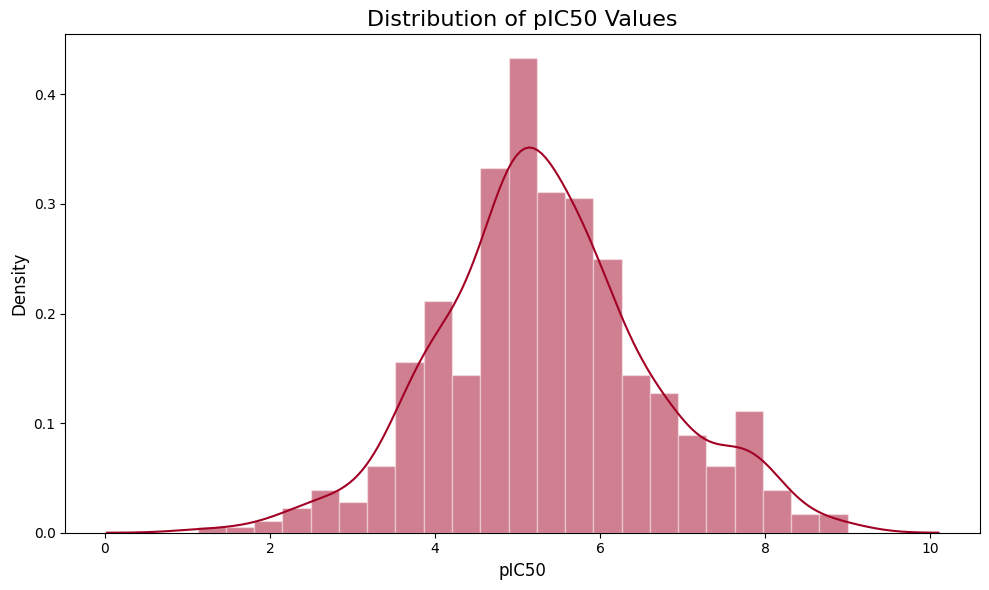

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(
    herg_blockers["pIC50"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.title("Distribution of pIC50 Values", fontsize=16)
plt.xlabel("pIC50", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()
plt.savefig("figures/ch03/distribution_pic50.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch03/distribution_pic50.png", bbox_inches='tight', dpi=600)

In real-world datasets, annotation errors, unit conversion mistakes, or other data quality issues can occur. Let's simulate such an error to understand how it would affect our distribution.

Specifically, we'll visualize what would happen if some compounds had incorrectly measured pIC50 values (by adding 3.0 to some values).


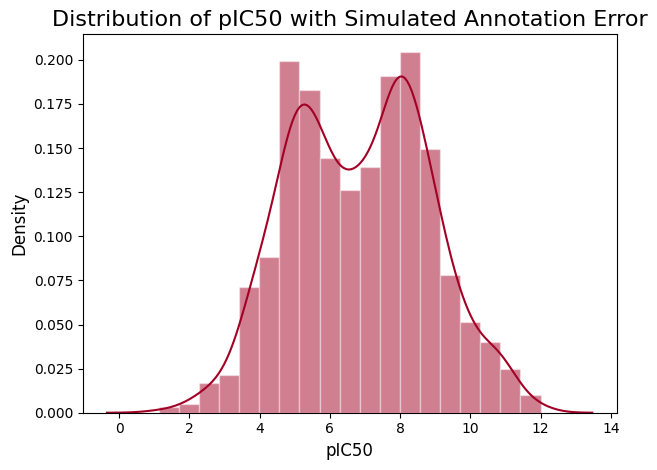

In [ ]:
# Simulate annotation error by adding 3.0 to the pIC50 values
def simulate_annotation_error(df, col="pIC50", error_value=3.0):
    """
    Simulate annotation errors in a dataset by adding an error value to all entries.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the data
        col (str): Column name to modify
        error_value (float): Error value to add
        
    Returns:
        pandas.Series: Series with simulated errors
    """
    return df[col] + error_value

simulated_error = simulate_annotation_error(herg_blockers, "pIC50", + 3.0)
herg_blockers_with_error = pd.concat([herg_blockers["pIC50"], simulated_error], ignore_index=True)
sns.histplot(
    herg_blockers_with_error, kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.title("Distribution of pIC50 with Simulated Annotation Error", fontsize=16)
plt.xlabel("pIC50", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()
plt.savefig("figures/ch03/distribution_pic50_error.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch03/distribution_pic50_error.png", bbox_inches='tight', dpi=600)

### <b> <font color='#A20025'> Validating & Standardizing SMILES

Let's visualize some examples from our dataset to understand what molecules with high and low pIC50 values look like.

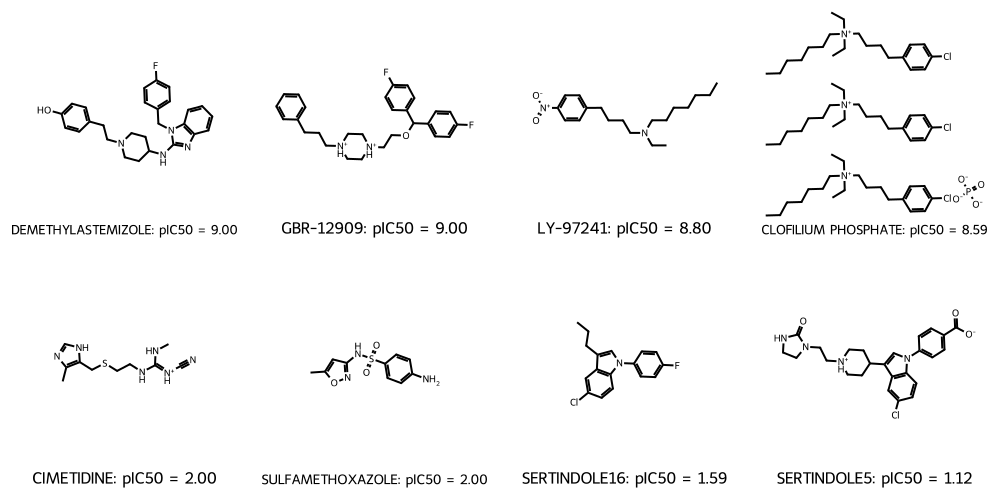

In [30]:
def visualize_extreme_molecules(df, activity_col="pIC50", name_col="Name", smiles_col="SMILES", n=4):
    """
    Visualize molecules with extreme activity values.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the data
        activity_col (str): Column name with activity values
        name_col (str): Column name with compound names
        smiles_col (str): Column name with SMILES strings
        n (int): Number of molecules to show from each extreme
        
    Returns:
        rdkit.Chem.Draw._MolsToGridImage: Grid image of molecules
    """
    # Sort the dataframe by activity
    df_sorted = df.sort_values(activity_col, ascending=False)
    
    # Get the highest and lowest n molecules
    extremes = pd.concat([df_sorted.head(n), df_sorted.dropna().tail(n)])
    
    # Convert SMILES to molecules
    mols = [Chem.MolFromSmiles(smi) for smi in extremes[smiles_col]]
    
    # Create legends with name and activity
    legends = [
        f"{name}: pIC50 = {activity:.2f}" 
        for name, activity in zip(extremes[name_col], extremes[activity_col])
    ]
    
    # Create the visualization
    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=n,
        subImgSize=(250, 250),
        legends=legends,
        useSVG=True,
        drawOptions=rdkit_drawing_options
    )
    
    # Save the image
    with open("figures/ch03/rdkit_extremes.svg", "w") as f:
        f.write(img.data)
    
    return img

# Visualize extreme molecules
extremes_img = visualize_extreme_molecules(herg_blockers)
display(extremes_img)


SMILES (Simplified Molecular Input Line Entry System) strings represent molecular structures.
Chemical representations like SMILES strings often need standardization to ensure consistent handling of molecules.
To ensure consistent processing, we need to standardize these strings by:
1. Converting SMILES to molecule objects
2. Cleaning up the molecules
3. Selecting the largest fragment (for salts or in case of mixtures)
4. Neutralizing charges
5. Canonicalizing tautomers (convert to a standard form)


In [23]:
def process_smiles(smi):
    """
    Process SMILES strings to create standardized molecule objects.
    
    Args:
        smi (str): SMILES string representing a molecule
        
    Returns:
        rdkit.Chem.Mol: Standardized RDKit molecule object
    """
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smi)
    
    if mol is None:
        return None
    
    # Apply standardization steps
    mol = Cleanup(mol)  # Remove reactive groups, standardize bonds
    mol = LargestFragmentChooser().choose(mol)  # Select largest fragment (removes salts)
    mol = Uncharger().uncharge(mol)  # Neutralize charges where possible
    mol = TautomerEnumerator().Canonicalize(mol)  # Standardize tautomers
    
    return mol

# Apply standardization to all molecules in the dataset
herg_blockers["mol"] = herg_blockers["SMILES"].apply(process_smiles)

# Count non-standardizable molecules
invalid_mols = herg_blockers[herg_blockers["mol"].isna()]
if len(invalid_mols) > 0:
    print(f"Warning: {len(invalid_mols)} molecules could not be standardized.")
    herg_blockers = herg_blockers.dropna(subset=["mol"])

[19:02:02] Initializing MetalDisconnector
[19:02:02] Running MetalDisconnector
[19:02:02] Initializing Normalizer
[19:02:02] Running Normalizer
[19:02:02] Running LargestFragmentChooser
[19:02:02] Running Uncharger
[19:02:02] Initializing MetalDisconnector
[19:02:02] Running MetalDisconnector
[19:02:02] Initializing Normalizer
[19:02:02] Running Normalizer
[19:02:02] Running LargestFragmentChooser
[19:02:02] Running Uncharger
[19:02:02] Initializing MetalDisconnector
[19:02:02] Running MetalDisconnector
[19:02:02] Initializing Normalizer
[19:02:02] Running Normalizer
[19:02:02] Running LargestFragmentChooser
[19:02:02] Running Uncharger
[19:02:02] Initializing MetalDisconnector
[19:02:02] Running MetalDisconnector
[19:02:02] Initializing Normalizer
[19:02:02] Running Normalizer
[19:02:02] Running LargestFragmentChooser
[19:02:02] Fragment: CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1
[19:02:02] New largest fragment: CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1 (60)
[19:02:02] Fragment: CCCCCCC[N+](CC)(C

Let's visualize some examples to see how standardization affects molecular representations.

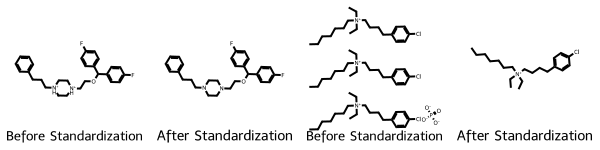

In [25]:
# Select a couple of examples to show before and after standardization
before_and_after_mols = [
    Chem.MolFromSmiles(herg_blockers.iloc[1].SMILES), 
    herg_blockers.iloc[1].mol, 
    Chem.MolFromSmiles(herg_blockers.iloc[3].SMILES), 
    herg_blockers.iloc[3].mol
]
legend_text = ["Before Standardization", "After Standardization"] * 2

# Create a grid of molecule visualizations
img = Draw.MolsToGridImage(
    before_and_after_mols, molsPerRow=4, subImgSize=(150, 150), 
    legends=legend_text, useSVG=True, drawOptions=rdkit_drawing_options,
)

# Save the visualization
with open("figures/ch03/rdkit_before_and_after.svg", "w") as f:
    f.write(img.data)

# Display the visualization
display(img)

### <b> <font color='#A20025'> Feature Generation & Exploration

To apply machine learning, we need to convert molecules into numerical features.
We'll use Morgan fingerprints, which are circular fingerprints that capture
the presence of specific substructures in molecules.

In [31]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

# Define function to compute Morgan fingerprints
def compute_fingerprint(mol, radius=2, nBits=2048):
    """Generate Morgan fingerprint for a molecule"""
    morgan_generator = GetMorganGenerator(radius=radius, fpSize=nBits)
    if mol is None:
        return None
    return morgan_generator.GetFingerprintAsNumPy(mol)

fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in herg_blockers.mol])
fingerprints.shape

(587, 2048)

Let's explore the fingerprint features to better understand our data representation.

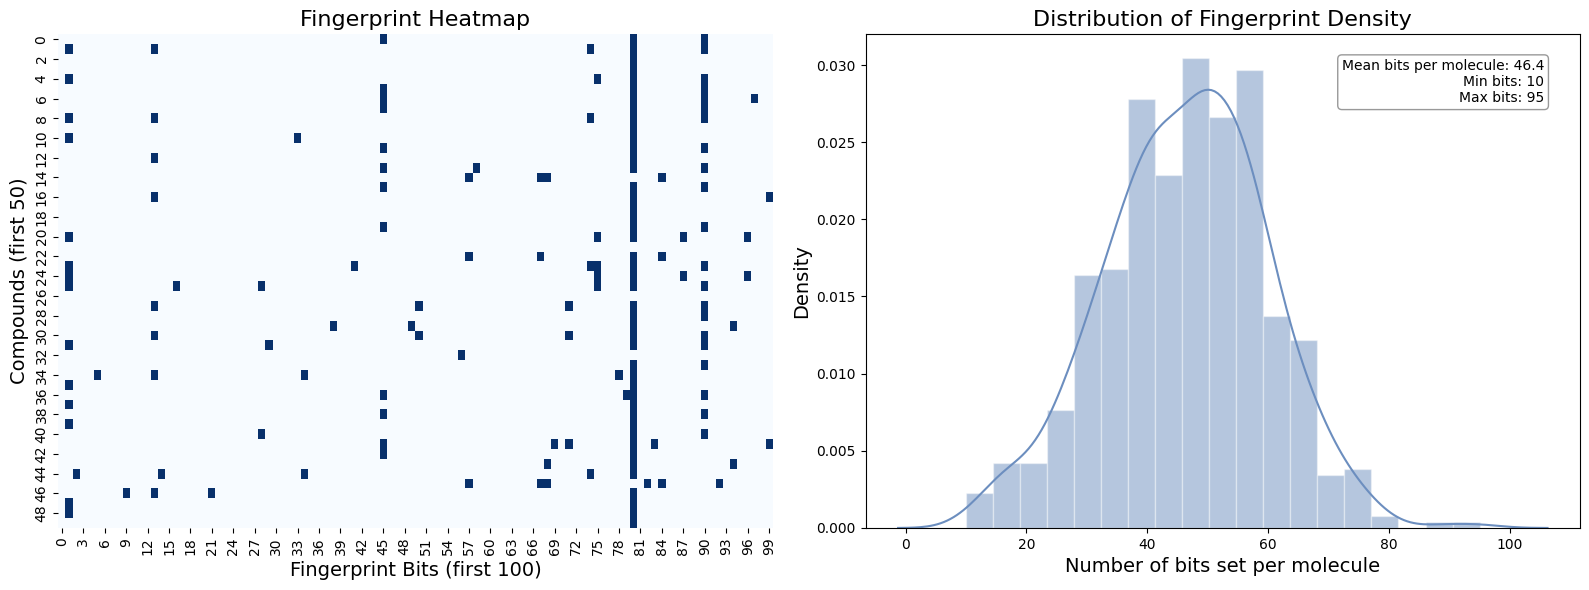

In [38]:
def explore_fingerprint_features(fingerprints):
    """
    Explore fingerprint features through visualizations.
    
    Parameters:
        fingerprints (numpy.ndarray): Array of fingerprints
        
    Returns:
        matplotlib.figure.Figure: Figure containing the visualizations
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    # Heatmap of fingerprints (first 50 compounds, first 100 bits)
    sns.heatmap(
        fingerprints[:50, :100],
        cbar=False,
        cmap="Blues",
        #cmap='Greys',
        ax=ax[0]
    )
    ax[0].set_xlabel("Fingerprint Bits (first 100)", fontsize=14)
    ax[0].set_ylabel("Compounds (first 50)", fontsize=14)
    ax[0].set_title("Fingerprint Heatmap", fontsize=16)
    
    # Distribution of bit counts per molecule
    bit_counts = fingerprints.sum(axis=1)
    sns.histplot(
        bit_counts,
        kde=True,
        stat="density",
        kde_kws=dict(cut=3),
        edgecolor=(1, 1, 1, .4),
        color="#6C8EBF",
        ax=ax[1]
    )
    ax[1].set_xlabel("Number of bits set per molecule", fontsize=14)
    ax[1].set_ylabel("Density", fontsize=14)
    ax[1].set_title("Distribution of Fingerprint Density", fontsize=16)
    
    # Add annotations about fingerprint statistics
    ax[1].annotate(
        f"Mean bits per molecule: {bit_counts.mean():.1f}\n"
        f"Min bits: {bit_counts.min()}\n"
        f"Max bits: {bit_counts.max()}",
        xy=(0.95, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig("figures/ch03/fingerprint_eda.svg", bbox_inches='tight', dpi=600)
    plt.savefig("figures/ch03/fingerprint_eda.png", bbox_inches='tight', dpi=600)
    
    return fig

# Explore fingerprint features
fp_fig = explore_fingerprint_features(fingerprints)

## <b> <font color='#A20025'> 3️⃣ Application of Linear Models

Now that we have prepared our dataset and generated features, let's build a machine learning model to predict hERG inhibition.

### <b> <font color='#A20025'> Training our Linear Model

We'll start with a simple linear model using Stochastic Gradient Descent (SGD). First, let's split our data into training and testing sets based on the provided split information.

In [40]:
def split_data(df, split_col="Random Split", train_pattern="Train", test_pattern="Test"):
    """
    Split data into training and testing sets based on a split column.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the data
        split_col (str): Column name with split information
        train_pattern (str): Pattern to identify training examples
        test_pattern (str): Pattern to identify test examples
        
    Returns:
        tuple: (train_df, test_df) DataFrames with training and testing data
    """
    # Extract indices for train and test sets
    train_mask = df[split_col].str.contains(train_pattern)
    test_mask = df[split_col].str.contains(test_pattern)
    
    # Create train and test dataframes
    train_df = df[train_mask].copy().reset_index(drop=True)
    test_df = df[test_mask].copy().reset_index(drop=True)
    
    # Shuffle the data
    train_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    print(f"Split data into {len(train_df)} training and {len(test_df)} testing examples")
    return train_df, test_df

train_set, test_set = split_data(herg_blockers)

Split data into 392 training and 195 testing examples


In [43]:
def train_sgd_classifier(X_train, y_train, **kwargs):
    """
    Train a Stochastic Gradient Descent classifier.
    
    Parameters:
        X_train (numpy.ndarray): Training features
        y_train (numpy.ndarray): Training labels
        **kwargs: Additional parameters for SGDClassifier
        
    Returns:
        sklearn.linear_model.SGDClassifier: Trained classifier
    """
    # Default parameters
    params = {
        'random_state': RANDOM_SEED,
        'max_iter': 1000,
        'tol': 1e-3
    }
    
    # Update with any provided parameters
    params.update(kwargs)
    
    # Create and train the classifier
    clf = SGDClassifier(**params)
    clf.fit(X_train, y_train)
    
    return clf

train_fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in train_set.mol])
train_labels = train_set.Class

lin_cls = train_sgd_classifier(train_fingerprints, train_labels)

print("Linear model training completed")

# Show a sample of predictions
herg_blockers_pred = lin_cls.predict(train_fingerprints)
sample_size = min(10, len(herg_blockers_pred))
print(f"Sample of {sample_size} predictions: {herg_blockers_pred[:sample_size]}")
print(f"Sample of {sample_size} true labels: {train_labels[:sample_size].values}")

Linear model training completed
Sample of 10 predictions: [1 0 1 1 0 1 1 1 1 1]
Sample of 10 true labels: [1 0 1 1 0 1 1 1 1 1]


### <b> <font color='#A20025'> Evaluating our Linear Model

Let's evaluate our model's performance using various metrics.

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, herg_blockers_pred)

0.9642857142857143

In [45]:
from sklearn.model_selection import cross_validate

scoring = {'acc': 'accuracy'}
lin_cls_scores = cross_validate(lin_cls, train_fingerprints, train_labels, scoring=scoring, cv=5)
lin_cls_scores["test_acc"].mean()

0.7933463161311263

In [46]:
from sklearn.dummy import DummyClassifier

# Train a dummy classifier (most frequent strategy)
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)
dummy_clf.fit(train_fingerprints, train_labels)
accuracy_score(train_labels, dummy_clf.predict(train_fingerprints))

0.6938775510204082

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_labels, herg_blockers_pred)

array([[119,   1],
       [ 13, 259]])

In [48]:
scoring = {
  'acc': 'accuracy',
  'prec_macro': 'precision',
  'rec_macro': 'recall',
  'f1_macro': 'f1',
}
lin_cls_scores = cross_validate(lin_cls, train_fingerprints, train_labels, scoring=scoring, cv=5, return_train_score=True)
lin_cls_scores_df = pd.DataFrame.from_dict(lin_cls_scores)
lin_cls_scores_df.describe().round(3)

,fit_time,score_time,test_acc,train_acc,test_prec_macro,train_prec_macro,test_rec_macro,train_rec_macro,test_f1_macro,train_f1_macro
count,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000
mean,0.065,0.020,0.793,0.978,0.861,0.992,0.845,0.977,0.850,0.984
std,0.018,0.004,0.038,0.008,0.060,0.006,0.066,0.013,0.028,0.006
min,0.042,0.013,0.744,0.965,0.804,0.986,0.741,0.954,0.818,0.974
25%,0.053,0.019,0.782,0.978,0.817,0.986,0.833,0.977,0.825,0.984
50%,0.065,0.021,0.785,0.981,0.833,0.991,0.852,0.982,0.852,0.986
75%,0.080,0.022,0.810,0.981,0.920,0.995,0.891,0.986,0.870,0.986
max,0.086,0.024,0.846,0.987,0.930,1.000,0.909,0.986,0.885,0.991


Let's visualize the cross-validation results to better understand the model's performance and potential overfitting.

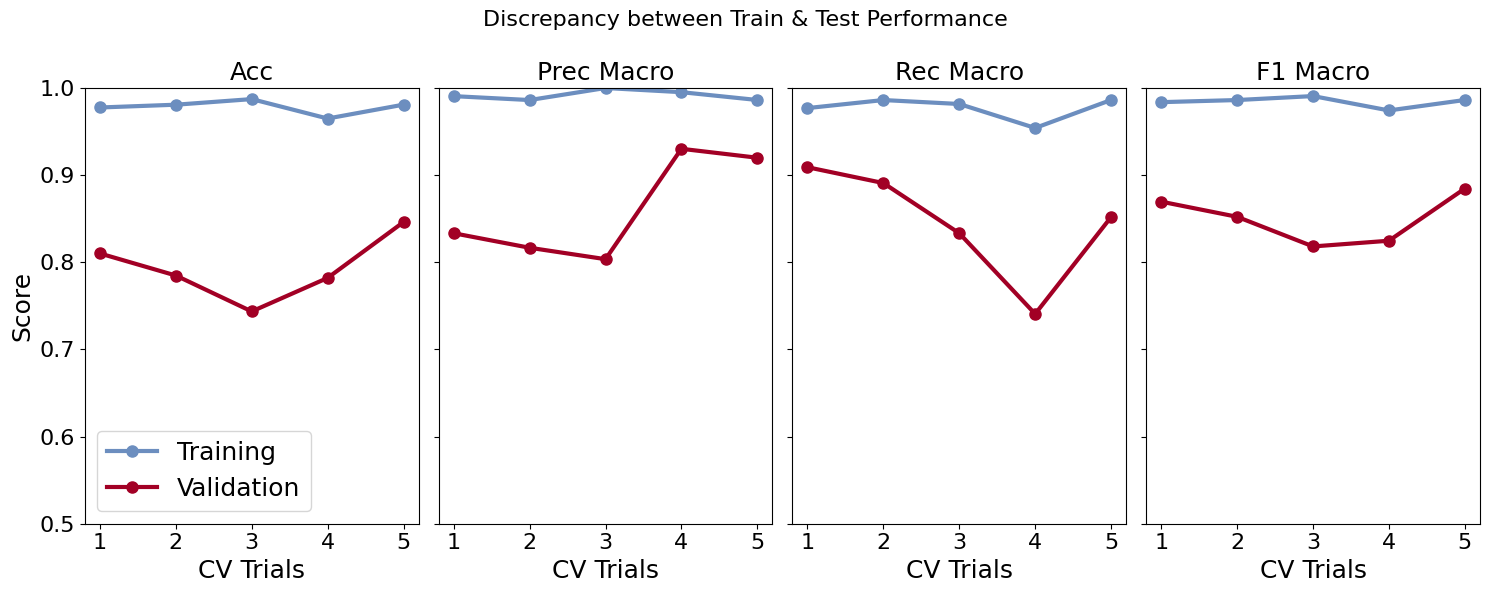

In [61]:
def visualize_cv_results(cv_df):
    """
    Visualize cross-validation results.
    
    Parameters:
        cv_df (pandas.DataFrame): DataFrame with cross-validation results
        
    Returns:
        matplotlib.figure.Figure: Figure with visualization
    """
    # Extract metric names
    metrics = [col.split('_', 1)[1] for col in cv_df.columns if col.startswith('test_')]
    
    # Create a subplot for each metric
    fig, axes = plt.subplots(1, len(metrics), figsize=(15, 6), sharey=True)
    fig.suptitle("Discrepancy between Train & Test Performance", fontsize=16)
    
    # Set y-axis limits for all subplots
    ylim = (0.5, 1.0)
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Get train and test scores for this metric
        train_scores = cv_df[f'train_{metric}']
        test_scores = cv_df[f'test_{metric}']
        
        # Plot the scores
        x = range(1, len(train_scores) + 1)
        ax.plot(x, train_scores, 'o-', label='Training', color='#6C8EBF', linewidth=3, markersize=8)
        ax.plot(x, test_scores, 'o-', label='Validation', color='#A20025', linewidth=3, markersize=8)
        
        # Set labels and title
        ax.set_title(metric.replace('_', ' ').title(), fontsize=18)
        ax.set_xlabel('CV Trials', fontsize=18)
        if i == 0:
            ax.set_ylabel('Score', fontsize=18)
        
        # Set x-ticks
        ax.set_xticks(x)
        
        # Set y-axis limits
        ax.set_ylim(ylim)
        
        # Add legend only to the first subplot
        if i == 0:
            ax.legend(fontsize=18)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    
    # Save the figure
    plt.savefig('figures/ch03/cv_metrics_discrepancy.svg', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch03/cv_metrics_discrepancy.png', bbox_inches='tight', dpi=600)
    
    return fig

cv_fig = visualize_cv_results(lin_cls_scores_df)

## <b> <font color='#A20025'> 4️⃣ Improving our Model

Let's improve our model by applying regularization and tuning hyperparameters.

### <b> <font color='#A20025'> Regularization

Regularization helps prevent overfitting by penalizing large model weights. Let's examine the distribution of weights in our unregularized model and then apply regularization.

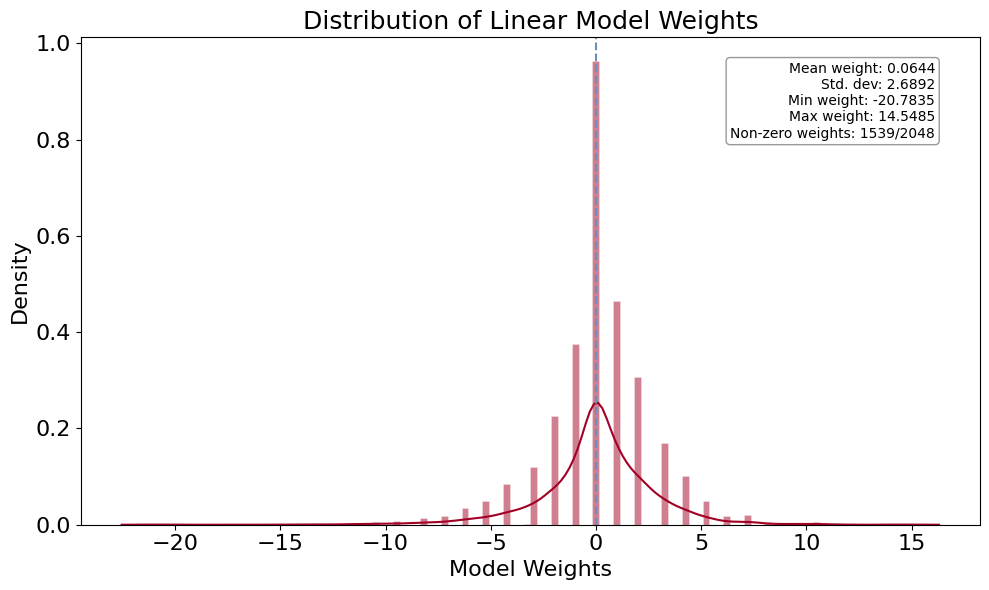

In [91]:
def visualize_model_weights(model):
    """
    Visualize the distribution of weights in a linear model.
    
    Parameters:
        model (object): Trained linear model with coef_ attribute
        
    Returns:
        matplotlib.figure.Figure: Figure with visualization
    """
    # Extract weights from the model or pipeline
    if hasattr(model, 'named_steps') and 'sgdclassifier' in model.named_steps:
        weights = model.named_steps['sgdclassifier'].coef_.squeeze()
    else:
        weights = model.coef_.squeeze()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot histogram with KDE
    sns.histplot(
        weights,
        kde=True,
        stat="density",
        kde_kws=dict(cut=3),
        edgecolor=(1, 1, 1, .4),
        color="#A20025",
    )
    
    # Add annotations about weight statistics
    plt.annotate(
        f"Mean weight: {weights.mean():.4f}\n"
        f"Std. dev: {weights.std():.4f}\n"
        f"Min weight: {weights.min():.4f}\n"
        f"Max weight: {weights.max():.4f}\n"
        f"Non-zero weights: {np.count_nonzero(weights)}/{len(weights)}",
        xy=(0.95, 0.95),
        xycoords='axes fraction',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Add vertical line at zero
    plt.axvline(x=0, color='#6C8EBF', linestyle='--')
    
    plt.xlabel("Model Weights")
    plt.ylabel("Density")
    plt.title("Distribution of Linear Model Weights")
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('figures/ch03/model_weights_displot.svg', bbox_inches='tight', dpi=600)
    plt.savefig('figures/ch03/model_weights_displot.png', bbox_inches='tight', dpi=600)
    
    return plt.gcf()

# Visualize model weights
weights_fig = visualize_model_weights(lin_cls)

### <b> <font color='#A20025'> Hyperparameter Tuning

To make our workflow more reproducible and maintainable, let's create a complete pipeline for molecule processing, from SMILES to features.

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline

class SmilesToMols(BaseEstimator, TransformerMixin):
    """Transformer that converts SMILES strings to RDKit molecules."""
    
    def fit(self, X, y=None):
        return self
    
    def _process_smiles(self, smi):
        """Process a SMILES string to create a standardized molecule."""
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                return None
            
            mol = Cleanup(mol)
            mol = LargestFragmentChooser().choose(mol)
            mol = Uncharger().uncharge(mol)
            mol = TautomerEnumerator().Canonicalize(mol)
            
            return mol
        except Exception as e:
            print(f"Error processing SMILES {smi}: {str(e)}")
            return None
    
    def transform(self, X, y=None):
        """Transform SMILES strings to RDKit molecules."""
        print("Converting SMILES to molecules...")
        mols = [self._process_smiles(smi) for smi in X]
        return np.asarray(mols, dtype=object)

class FingerprintFeaturizer(BaseEstimator, TransformerMixin):
    """Transformer that converts RDKit molecules to fingerprints."""
    
    def __init__(self, radius=2, nBits=2048):
        self.radius = radius
        self.nBits = nBits
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """Transform molecules to fingerprints."""
        print(f"Generating fingerprints (radius={self.radius}, nBits={self.nBits})...")
        
        from rdkit import DataStructs
        
        # Function to compute fingerprint for a single molecule
        def compute_fp(mol):
            if mol is None:
                return np.zeros(self.nBits, dtype=np.int8)
            
            morgan_generator = GetMorganGenerator(radius=self.radius, fpSize=self.nBits)
            return morgan_generator.GetFingerprintAsNumPy(mol)
        
        # Apply to all molecules
        fingerprints = [compute_fp(mol) for mol in X]
        return np.vstack(fingerprints)

Let's use grid search and cross-validation to find the best hyperparameters for our model.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

def tune_model_hyperparameters(X, y, n_iter=20, cv=5):
    """
    Tune model hyperparameters using grid search.
    
    Parameters:
        X (array-like): Features
        y (array-like): Labels
        n_iter (int): Number of iterations for randomized search
        cv (int): Number of cross-validation folds
        
    Returns:
        tuple: (best_estimator, cv_results_df) The best estimator and CV results
    """
    # Create a temporary cache directory
    cachedir = "gs_linear_sgd"

    # Create the pipeline
    pipe = make_pipeline(
        SmilesToMols(),
        FingerprintFeaturizer(),
        SGDClassifier(random_state=RANDOM_SEED),
        memory=cachedir
    )
    
    # Define parameter grid
    param_grid = [{
        'sgdclassifier__penalty': ["l2", "l1"],
        'sgdclassifier__alpha': [1e-3, 1e-2, 1e-1],
        'fingerprintfeaturizer__radius': [2, 4],
        'fingerprintfeaturizer__nBits': [1024, 2048],
    }]
        
    # Determine which search method to use
    print("Performing grid search for hyperparameter tuning...")
    search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="f1",
        cv=cv,
        verbose=1,
    )

    # Perform the search
    search.fit(X, y)
    
    # Extract results
    print(f"Best parameters: {search.best_params_}")
    print(f"Best score: {search.best_score_:.4f}")
    
    # Convert results to DataFrame
    cv_results_df = pd.DataFrame(search.cv_results_)
    
    return search.best_estimator_, cv_results_df

X_smiles = herg_blockers['SMILES'].values
y_labels = herg_blockers['Class'].values

# Tune the model
best_model_gs, cv_results = tune_model_hyperparameters(X_smiles, y_labels)

# Save the best model
joblib.dump(best_model_gs, "artifacts/ch03/herg_blockers_cls_model.pkl")
print("Best model saved to 'artifacts/ch03/herg_blockers_cls_model.pkl'")

In [ ]:
# Display top results
top_results = cv_results.sort_values('mean_test_score', ascending=False).head(5)
print("Top 5 parameter combinations:")
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    display(top_results[['params', 'mean_test_score', 'std_test_score']])

Top 5 parameter combinations:


,params,mean_test_score,std_test_score
15,"{'fingerprintfeaturizer__nBits': 2048, 'fingerprintfeaturizer__radius': 2, 'sgdclassifier__alpha': 0.01, 'sgdclassifier__penalty': 'l1'}",0.851563,0.026940
3,"{'fingerprintfeaturizer__nBits': 1024, 'fingerprintfeaturizer__radius': 2, 'sgdclassifier__alpha': 0.01, 'sgdclassifier__penalty': 'l1'}",0.851422,0.021919
9,"{'fingerprintfeaturizer__nBits': 1024, 'fingerprintfeaturizer__radius': 4, 'sgdclassifier__alpha': 0.01, 'sgdclassifier__penalty': 'l1'}",0.849858,0.041465
21,"{'fingerprintfeaturizer__nBits': 2048, 'fingerprintfeaturizer__radius': 4, 'sgdclassifier__alpha': 0.01, 'sgdclassifier__penalty': 'l1'}",0.849098,0.023591
16,"{'fingerprintfeaturizer__nBits': 2048, 'fingerprintfeaturizer__radius': 2, 'sgdclassifier__alpha': 0.1, 'sgdclassifier__penalty': 'l2'}",0.847988,0.014627


Let's see if we get different results with a randomized search and slightly modified pipeline, including a nonlinear transformation.

In [ ]:
def tune_model_hyperparameters_randomized_search(X, y, n_iter=20, cv=5):
    """
    Tune model hyperparameters using grid search.
    
    Parameters:
        X (array-like): Features
        y (array-like): Labels
        n_iter (int): Number of iterations for randomized search
        cv (int): Number of cross-validation folds
        
    Returns:
        tuple: (best_estimator, cv_results_df) The best estimator and CV results
    """
    # Create a temporary cache directory
    cachedir = "rs_nonlinear_sgd"

    # Create the pipeline
    pipe = make_pipeline(
        FingerprintFeaturizer(),  # Transformer: Feature generation step
        PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),  # Transformer: Nonlinear feature transform
        SGDClassifier(max_iter=5000, random_state=RANDOM_SEED, early_stopping=True),  # Estimator: SGDClassifier (Logistic Regressor)
        memory=cachedir
    )
    
    # Define parameter distribution
    param_dist = [{
        'sgdclassifier__penalty': ["l2", "l1"],
        'sgdclassifier__alpha': sp_rand(0.01),
        'fingerprintfeaturizer__radius': [2, 4],
        'fingerprintfeaturizer__nBits': [64, 128, 256],
    }]
        
    # Determine which search method to use
    print("Performing randomized search for hyperparameter tuning...")
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        scoring="f1",
        cv=cv,
        n_iter=n_iter,
    )

    # Perform the search
    search.fit(X, y)
    
    # Extract results
    print(f"Best parameters: {search.best_params_}")
    print(f"Best score: {search.best_score_:.4f}")
    
    # Convert results to DataFrame
    cv_results_df = pd.DataFrame(search.cv_results_)
    
    return search.best_estimator_, cv_results_df

# Tune the model
best_model_rs, cv_results_rs = tune_model_hyperparameters_randomized_search(train_set.mol, train_set.Class)

# Save the best model
joblib.dump(best_model_rs, "artifacts/ch03/herg_blockers_cls_model_rs.pkl")
print("Best model saved to 'artifacts/ch03/herg_blockers_cls_model_rs.pkl'")

In [76]:
# Display top results
top_results_rs = cv_results_rs.sort_values('mean_test_score', ascending=False).head(5)
print("Top 5 parameter combinations:")
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    display(top_results_rs[['params', 'mean_test_score', 'std_test_score']])

Top 5 parameter combinations:


,params,mean_test_score,std_test_score
2,"{'fingerprintfeaturizer__nBits': 256, 'fingerprintfeaturizer__radius': 2, 'sgdclassifier__alpha': 0.46924889196586717, 'sgdclassifier__penalty': 'l2'}",0.851126,0.036311
10,"{'fingerprintfeaturizer__nBits': 64, 'fingerprintfeaturizer__radius': 2, 'sgdclassifier__alpha': 0.8699404067363206, 'sgdclassifier__penalty': 'l2'}",0.831946,0.018115
3,"{'fingerprintfeaturizer__nBits': 256, 'fingerprintfeaturizer__radius': 4, 'sgdclassifier__alpha': 0.06641157902710025, 'sgdclassifier__penalty': 'l1'}",0.831938,0.017094
1,"{'fingerprintfeaturizer__nBits': 64, 'fingerprintfeaturizer__radius': 2, 'sgdclassifier__alpha': 0.16601864044243653, 'sgdclassifier__penalty': 'l2'}",0.830053,0.049026
18,"{'fingerprintfeaturizer__nBits': 64, 'fingerprintfeaturizer__radius': 2, 'sgdclassifier__alpha': 0.8522847745949985, 'sgdclassifier__penalty': 'l1'}",0.819267,0.001329


### <b> <font color='#A20025'> Evaluating the Best Models

When we compare the resulting, regularized model weights for each model we see that both distributions were compressed to a narrower range of weight magnitudes (as seen by comparing the x-axes). However, the best model from grid search used an L1 penalty, which drove the majority of weights to zero, functioning like feature extraction. In contrast, the best model from randomized search used an L2 penalty, which kept more nonzero weights but at smaller magnitudes. 

Why does the best model from randomized search have much more than 2048 weights? Because of the explosion of features due to the application of the polynomial feature transformation!"

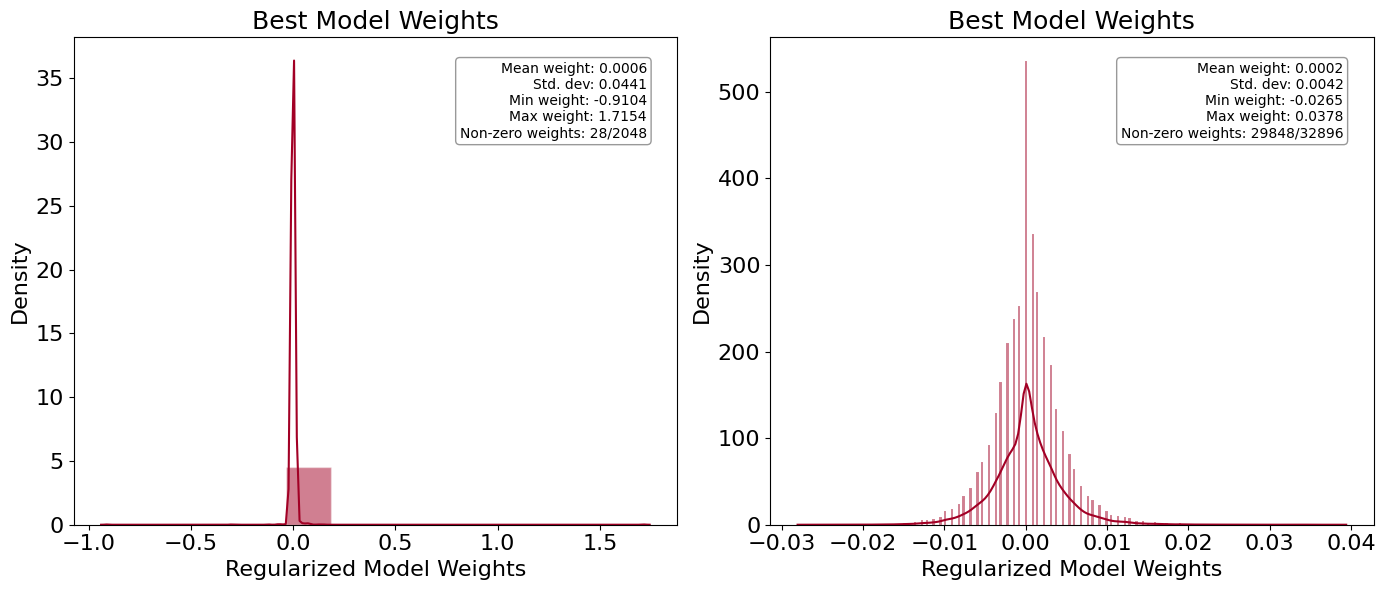

In [90]:
# Extract model weights from both models
best_model_gs_weights = best_model_gs.named_steps["sgdclassifier"].coef_.squeeze()
best_model_rs_weights = best_model_rs.named_steps["sgdclassifier"].coef_.squeeze()

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for final model
sns.histplot(
    best_model_gs_weights, kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
    ax=axes[0]
)
axes[0].set_title("Best Model Weights")
axes[0].set_xlabel("Regularized Model Weights")

# Plot for best model
sns.histplot(
    best_model_rs_weights, kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
    ax=axes[1]
)
axes[1].set_title("Best Model Weights")
axes[1].set_xlabel("Regularized Model Weights")

# Add annotations for final model
axes[0].annotate(
    f"Mean weight: {best_model_gs_weights.mean():.4f}\n"
    f"Std. dev: {best_model_gs_weights.std():.4f}\n"
    f"Min weight: {best_model_gs_weights.min():.4f}\n"
    f"Max weight: {best_model_gs_weights.max():.4f}\n"
    f"Non-zero weights: {np.count_nonzero(best_model_gs_weights)}/{len(best_model_gs_weights)}",
    xy=(0.95, 0.95),
    xycoords='axes fraction',
    ha='right',
    va='top',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

# Add annotations for best model
axes[1].annotate(
    f"Mean weight: {best_model_rs_weights.mean():.4f}\n"
    f"Std. dev: {best_model_rs_weights.std():.4f}\n"
    f"Min weight: {best_model_rs_weights.min():.4f}\n"
    f"Max weight: {best_model_rs_weights.max():.4f}\n"
    f"Non-zero weights: {np.count_nonzero(best_model_rs_weights)}/{len(best_model_rs_weights)}",
    xy=(0.95, 0.95),
    xycoords='axes fraction',
    ha='right',
    va='top',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)

plt.tight_layout()
plt.savefig("figures/ch03/regularized_model_weights_comparison.svg", bbox_inches='tight', dpi=600)
plt.savefig("figures/ch03/regularized_model_weights_comparison.png", bbox_inches='tight', dpi=600)

Let's identify and visualize the most important features (fingerprint bits) for one of our models.

In [92]:
important_bits = np.argwhere(best_model_gs_weights).flatten()
important_bits.shape

(28,)

In [99]:
N = 3

top_ind_unsorted = np.argpartition(best_model_gs_weights, -N)[-N:]
top_ind_sorted = top_ind_unsorted[np.argsort(best_model_gs_weights[top_ind_unsorted])[::-1]]

bot_ind_unsorted = np.argpartition(best_model_gs_weights, N)[:N]
bot_ind_sorted = bot_ind_unsorted[np.argsort(best_model_gs_weights[bot_ind_unsorted])]

print(top_ind_sorted)
print(bot_ind_sorted)

top_bit_coefficients = best_model_gs_weights[top_ind_sorted]
bot_bit_coefficients = best_model_gs_weights[bot_ind_sorted]

print(top_bit_coefficients)
print(bot_bit_coefficients)

[1750 1088 1873]
[1294 1164    9]
[1.71541113 0.14600836 0.12425778]
[-0.91039625 -0.3011597  -0.1208204 ]


In [97]:
def draw_fragment_from_bit(mol, bit_number):
  """ Given an rdkit mol, draws the local fragment that corresponds to the set bit of ecfp featurization.

  If the bit is not set, will throw an error.
  """
  ao = AdditionalOutput()
  ao.AllocateBitInfoMap()
  morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
  fp = morgan_generator.GetFingerprint(mol, additionalOutput=ao)
  try:
    svg = Draw.DrawMorganBit(mol, bit_number, ao.GetBitInfoMap(), useSVG=True)
  except:
    raise ValueError(f"Featurization of mol doesn't have bit {bit_number} set")
  return svg

def get_examples_for_bit(bit_number, mols, fingerprints):
  """ For a given bit number, get a visual representation of what substructure it represents"""
  res = np.argwhere(fingerprints[:, bit_number] == 1)
  mols = np.array(mols)[res.flatten()]
  return [draw_fragment_from_bit(mols[i], bit_number) for i in range(len(mols))]

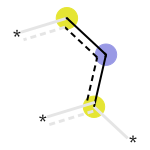

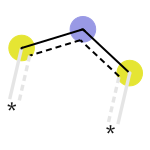

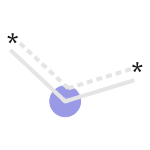

In [98]:
for i, bit in enumerate(top_ind_sorted):
  examples = get_examples_for_bit(bit, train_set.mol, train_fingerprints)
  with open(f"figures/ch03/top_example_bit{i}.svg", "w") as f:
    f.write(examples[0].data)
  display(examples[0])

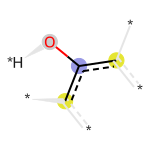

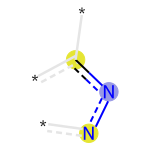

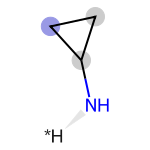

In [100]:
for i, bit in enumerate(bot_ind_sorted):
  examples = get_examples_for_bit(bit, train_set.mol, train_fingerprints)
  with open(f"figures/ch03/bot_example_bit{i}.svg", "w") as f:
    f.write(examples[0].data)
  display(examples[0])

Let's evaluate our final model on the test set.

In [ ]:
def evaluate_final_model(model, X_test, y_test, output_file=None):
    """
    Evaluate the final model on the test set.
    
    Parameters:
        model (object): Trained model
        X_test (array-like): Test features
        y_test (array-like): Test labels
        output_file (str): Path to save evaluation results
        
    Returns:
        dict: Dictionary with evaluation metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='macro')
    matthews_cc = matthews_corrcoef(y_test, y_pred)
    
    # Create a report
    report = (
        f"Final Model Evaluation on Test Set\n"
        f"==================================\n"
        f"F1 Score (macro): {f1:.4f}\n"
        f"\nMatthews Correlation Coefficient:\n{matthews_cc:.4f}\n"
    )
    
    # Print the report
    print(report)
    
    # Save the report if requested
    if output_file:
        with open(output_file, 'w') as f:
            f.write(report)
        print(f"Evaluation report saved to {output_file}")
    
    return {
        'f1_score': f1,
        'matthews_corrcoef': matthews_cc,
        'predictions': y_pred
    }

# Evaluate our final model on the test set
X_test_smiles = test_set['SMILES'].values
y_test = test_set['Class'].values

final_metrics = evaluate_final_model(
    best_model_gs,
    X_test_smiles,
    y_test,
    output_file="artifacts/ch03/final_model_evaluation.txt"
)

### <b> <font color='#A20025'> Saving and Applying our Model

In [ ]:
def save_load_model_demo(model_path="artifacts/ch03/herg_blockers_cls_model.pkl"):
    """
    Demonstrate how to save and load a model.
    
    Parameters:
        model_path (str): Path to the saved model
        
    Returns:
        object: Loaded model
    """
    # Import statements that would be needed in a new script
    demonstration_code = """
# Required imports for loading and using the model
import joblib
from rdkit import Chem
from rdkit.Chem import MolStandardize, AllChem
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer classes (same as defined earlier)
class SmilesToMols(BaseEstimator, TransformerMixin):
    # ... (class implementation) ...
    
class FingerprintFeaturizer(BaseEstimator, TransformerMixin):
    # ... (class implementation) ...

# Load the model
model = joblib.load("artifacts/ch03/herg_blockers_cls_model.pkl")

# Example usage
new_smiles = [
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # Aspirin
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"  # Caffeine
]

# Make predictions
predictions = model.predict(new_smiles)
probabilities = model.predict_proba(new_smiles)

print("Predictions:", predictions)
print("Probabilities:", probabilities)
"""
    
    print("Example code for loading and using the saved model:")
    print(demonstration_code)
    
    # Check if the model exists
    if os.path.exists(model_path):
        try:
            # Load the model
            loaded_model = joblib.load(model_path)
            print(f"Successfully loaded model from {model_path}")
            return loaded_model
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return None
    else:
        print(f"Model file {model_path} does not exist")
        return None

# Demonstrate how to save and load the model
loaded_model = save_load_model_demo()

if loaded_model is not None:
    # Test with a few examples
    example_smiles = [
        "CC(=O)OC1=CC=CC=C1C(=O)O",  # Aspirin
        "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"  # Caffeine
    ]
    
    predictions = loaded_model.predict(example_smiles)
    print(f"Predictions for example molecules: {predictions}")


In [ ]:
# Can also apply the loaded model on the previous hits we saved from the Malaria Box compounds in chapter 2!
malaria_box_hits = [...]  # Load the saved hits from chapter 2
predictions = loaded_model.predict(malaria_box_hits)

## <b> <font color='#A20025'> Summary

In this notebook, we've built a complete machine learning pipeline for predicting hERG channel inhibition, which is crucial for assessing drug cardiotoxicity. Our workflow included:
 
1. **Data Preprocessing**:
    - Loading and exploring the hERG inhibition dataset
    - Standardizing molecular structures
    - Generating Morgan fingerprints as features
 
2. **Model Building**:
    - Training a basic linear classifier
    - Improving the model with regularization
    - Tuning hyperparameters through grid search
 
3. **Model Evaluation**:
    - Using cross-validation to assess model performance
    - Comparing with a baseline model
    - Final evaluation on a held-out test set
 
4. **Model Interpretation**:
    - Visualizing model weights
    - Identifying important structural features
 
5. **Model Deployment**:
    - Saving the model for future use
    - Demonstrating how to load and apply the model to new compounds
 
This case study demonstrates a typical machine learning workflow in drug discovery and provides a foundation for building more sophisticated models for other molecular property prediction tasks.


## <b> <font color='#A20025'> Further Exploration

Here are some ideas for extending this work:
 
1. **Try different molecular representations**:
    - MACCS keys, topological fingerprints, or 3D descriptors
    - Graph-based representations (for use with graph neural networks)
 
2. **Explore different machine learning algorithms**:
    - Random forests, gradient boosting, or support vector machines
    - Deep learning approaches for molecular property prediction
 
3. **Address class imbalance**:
    - Apply techniques like SMOTE, class weighting, or focal loss
 
4. **Perform more extensive model interpretation**:
    - Use SHAP values or permutation importance
    - Develop matched molecular pairs to understand structure-activity relationships
 
5. **Extend to multi-task learning**:
    - Predict multiple toxicity endpoints simultaneously
    - Incorporate data from related targets

*See the book for more exercises.*
*Some exploration ideas may require reading ahead to downstream chapters*

## <b> <font color='#A20025'> References

[1] Overview of TDC Datasets. Therapeutics Data Commons. https://tdcommons.ai/overview/

[2] Chemical Structure validation / standardisation. Greg Landrum https://www.youtube.com/watch?v=eWTApNX8dJQ

[3] Linear Models. Scikit-Learn. https://scikit-learn.org/stable/modules/linear_model.html
